# HW7 - Convolutional Neural Networks
## Adrien Bourgain

In [1]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f'func: {f.__name__} took: {te-ts:.4f} sec')
        return result

    return timed


def load_dataset(path):
    with open(path, 'rb') as f:
        train_data, test_data = pickle.load(f)
    
    X_train = torch.tensor(train_data[0], dtype=torch.float).unsqueeze(1)
    y_train = torch.tensor(train_data[1], dtype=torch.long)
    X_test = torch.tensor(test_data[0], dtype=torch.float).unsqueeze(1)
    y_test = torch.tensor(test_data[1], dtype=torch.long)
    return X_train, y_train, X_test, y_test


class MnistDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class Trainer:
    
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2, device):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"-> {model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.device = device
        print(f"-> Train and evaluate model using: {device}.")
        if opt_method == "sgdm":
            self.optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9)
        elif opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
    
    @timeit
    def train(self, train_data, val_data, early_stop=True, verbose=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        train_loss_list, train_acc_list = [], []
        val_loss_list, val_acc_list = [], []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_func = nn.CrossEntropyLoss()
        for n in tqdm(range(self.epoch), leave=False):
            self.model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device) # load on the GPU if it exists
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
            train_loss, train_acc = self.evaluate(train_data)
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            
            val_loss, val_acc = self.evaluate(val_data)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].plot(x_axis, val_loss_list, label="Validation")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].plot(x_axis, val_acc_list, label='Validation')
            axes[1].set_title("Accuracy")
            axes[1].legend()
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "train_acc_list": train_acc_list,
            "val_loss_list": val_loss_list,
            "val_acc_list": val_acc_list,
        }
    
    def evaluate(self, data, print_acc=False):
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        loss_func = nn.CrossEntropyLoss()
        acc, loss = 0.0, 0.0
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device) # load on the GPU if it exists
            with torch.no_grad():
                batch_importance = y_batch.shape[0] / len(data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                batch_acc = torch.sum(torch.argmax(y_pred, axis=-1) == y_batch) / y_batch.shape[0]
                acc += batch_acc.detach().cpu().item() * batch_importance
                loss += batch_loss.detach().cpu().item() * batch_importance
        if print_acc:
            print(f"Accuracy: {acc:.3f}")
        return loss, acc
    

def KFoldCrossValidation(
    model_class, k, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', learning_rate=2e-3, batch_size=128, epoch=50, l2=0.0,
    device='cpu',
    early_break=False,
    **model_args
):
    test_data = MnistDataset(X_test, y_test)
    kf = KFold(n_splits=k, shuffle=True)
    train_acc_list, test_acc_list = [], []
    for i, (train_index, val_index) in enumerate(kf.split(X_train)):
        print(f"Fold {i}:")
        
        train_data = MnistDataset(X_train[train_index], y_train[train_index])
        val_data = MnistDataset(X_train[val_index], y_train[val_index])
        
        model = model_class(**model_args).to(device)
        
        trainer = Trainer(model, opt_method, learning_rate, batch_size, epoch, l2, device)
        res = trainer.train(train_data, val_data)
        train_acc_best = res['train_acc_list'][np.argmin(res['val_loss_list'])]
        test_loss, test_acc = trainer.evaluate(test_data)
        
        train_acc_list.append(train_acc_best)
        test_acc_list.append(test_acc)
        
        print(f"Training accuracy: {train_acc_best * 100:.2f}%")
        print(f"Test accuracy: {test_acc * 100:.2f}%")
        
        if early_break:
            break
    
    if not early_break:
        print("Final results:")
        print(f"\t-> Training accuracy: {np.mean(train_acc_list) * 100:.2f}% +/- {np.std(train_acc_list)  * 100:.2f}")
        print(f"\t-> Testing accuracy: {np.mean(test_acc_list) * 100:.2f}% +/- {np.std(test_acc_list)  * 100:.2f}")


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"device: {device}")

device: mps


# Question 1

We can define the following function to compute the dimensionality of the output after a convolution layer, with the following formula:
$$H_{\text {out }}=\left[\frac{H_{\text {in }}+2 \times \text { padding }-\operatorname{dilation} \times(\text { kernel size }-1)-1}{\text { stride }}+1\right]$$
We will consider dilation = 1.
We also have a similar formula for a max pooling layer:
$$H_{\text {out }}=\frac{H_{\text {in }} - \text{filter size F}}{\text { stride S}} + 1$$

In [3]:
def out_dim_conv(in_dim, kernel_size, padding, stride, dilation=1):
    return (in_dim + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

In [4]:
def out_dim_max_pool(in_dim, filter_size, stride):
    return (in_dim - filter_size) // stride + 1

Besides, the MNIST dataset has an input dimension of 32x32.



## (a)




### (i) Convolution Filter size of 2x2, number of filters 33, stride of 2, padding of 0:

Using the formula we have: 
$$H_{\text {out conv i}}= \frac{32 +2 \times 0 - 1 \times(2 - 1) -1}{2} + 1 = 16$$

In [5]:
out_dim_i = out_dim_conv(in_dim=32, kernel_size=2, padding=0, stride=2)
print(f"output dimensionality: {out_dim_i}")

output dimensionality: 16


After (i), the dimension is 16x16x33.

### (ii) Convolution Filter size of 3x3, number of filters 55, stride of 1, padding of 1:

Using the formula we have: 
$$H_{\text {out conv ii}}= \frac{16 +2 \times 1 - 1 \times(3 - 1) -1 }{1} + 1 = 16$$

In [6]:
out_dim_ii = out_dim_conv(in_dim=out_dim_i, kernel_size=3, padding=1, stride=1)
print(f"output dimensionality: {out_dim_ii}")

output dimensionality: 16


After (ii), the dimension is 16x16x55.

In [7]:
(16 -2)/2 +1

8.0

### (iii) Convolution Filter size of 3x3, number of filters 77, stride of 1, padding of 1. Followed by a Max Pooling with a filter size of 2x2 and stride 2:

Using the formula we have: 
$$H_{\text{out conv iii}}= \frac{16 + 2 \times 1 - 1 \times(3 - 1) -1}{1} + 1 = 16$$

and the max pooling:
$$H_{\text {out max pool iii}}=\frac{16 - 2}{2} + 1 = 8$$

In [8]:
out_dim_iii = out_dim_max_pool(
    in_dim=out_dim_conv(
        in_dim=out_dim_ii, 
        kernel_size=3, 
        padding=1, 
        stride=1
    ), 
    filter_size=2, 
    stride=2
)
print(f"output dimensionality: {out_dim_iii}")

output dimensionality: 8


**ANSWER:** The output dimension is finally 8x8x77.


## (b)

### (i) Convolution Filter size of 2x2, number of filters 33, stride of 2, padding of 0:

Using the formula we have: 
$$H_{\text {out conv i}}= \frac{32 +2 \times 0 - 1 \times(2 - 1) -1}{2} + 1 = 16$$

In [9]:
out_dim_i = out_dim_conv(in_dim=32, kernel_size=2, padding=0, stride=2)
print(f"output dimensionality: {out_dim_i}")

output dimensionality: 16


After (i), the dimension is 16x16x33.

### (ii) Convolution Filter size of 3x3, number of filters 55, stride of 1, padding of 1. Followed by a max pooling layer of kernel size 3x3, stride of 1, padding of 0:

Using the formula we have: 
$$H_{\text{out conv ii}}= \frac{16 + 2 \times 1 - 1 \times(3 - 1) -1}{1} + 1 = 16$$

and the max pooling:
$$H_{\text {out max pool ii}}=\frac{16 - 3}{1} + 1 = 14$$

In [10]:
out_dim_ii = out_dim_max_pool(
    in_dim=out_dim_conv(
        in_dim=out_dim_i, 
        kernel_size=3, 
        padding=1, 
        stride=1
    ), 
    filter_size=3, 
    stride=1
)
print(f"output dimensionality: {out_dim_ii}")

output dimensionality: 14


After (ii), the dimension is 14x14x55.

### (iii) Convolution Filter size of 3x3, number of filters 77, stride of 1, padding of 1. Followed by a Max Pooling with filter size of 2x2 and stride 2:

Using the formula we have: 
$$H_{\text{out conv iii}}= \frac{14 + 2 \times 1 - 1 \times(3 - 1) -1}{1} + 1 = 14$$

and the max pooling:
$$H_{\text {out max pool iii}}=\frac{14 - 2}{2} + 1 = 7$$

In [11]:
out_dim_iii = out_dim_max_pool(
    in_dim=out_dim_conv(
        in_dim=out_dim_ii, 
        kernel_size=3, 
        padding=1, 
        stride=1
    ), 
    filter_size=2, 
    stride=2
)
print(f"output dimensionality: {out_dim_iii}")

output dimensionality: 7


**ANSWER:** The output dimension is finally 7x7x77.

## (c)

### Instructions: For training stability, it is recommened to normalize the data by dividing its max value as you did in HW6.

In [12]:
# Normalize data
X_train, y_train, X_test, y_test = load_dataset("../Datasets/mnist.pkl") # load the dataset

X_train /= torch.max(X_train)
X_test /= torch.max(X_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([60000, 1, 32, 32])
X_test shape: torch.Size([10000, 1, 32, 32])
y_train shape: torch.Size([60000])
y_test shape: torch.Size([10000])


In [42]:
class ShallowCNN(nn.Module):
    def __init__(self, in_channels=1, in_dim=32):
        super().__init__()
        self.params = {
            "conv": {"in_channels": in_channels, "out_channels": 3, "kernel_size": 5, "stride": 1, "padding": 2},
        }
        self.conv = nn.Conv2d(
            in_channels=self.params["conv"]["in_channels"], 
            out_channels=self.params["conv"]["out_channels"], 
            kernel_size=self.params["conv"]["kernel_size"], 
            stride=self.params["conv"]["stride"], 
            padding=self.params["conv"]["padding"]
        )
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        out_dim = self._out_dim_conv(
            in_dim, self.params["conv"]["kernel_size"], 
            self.params["conv"]["padding"], 
            self.params["conv"]["stride"]
        )
        self.fc = nn.Linear(out_dim * out_dim * self.params["conv"]["out_channels"], 10)

    def forward(self, x):
        x = self.activation(self.conv(x))
        x = self.flatten(x)
        x = self.fc(x)
        return x

    def _out_dim_conv(self, in_dim, kernel_size, padding, stride, dilation=1):
        return (in_dim + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

    def _out_dim_max_pool(in_dim, filter_size, stride):
        return (in_dim - filter_size) // stride + 1

Fold 0:
-> ShallowCNN - Number of parameters: 30808
-> Train and evaluate model using: mps.


func: train took: 90.9557 sec
Training accuracy: 98.39%
Test accuracy: 97.06%
Fold 1:
-> ShallowCNN - Number of parameters: 30808
-> Train and evaluate model using: mps.


func: train took: 83.7439 sec
Training accuracy: 98.37%
Test accuracy: 97.51%
Fold 2:
-> ShallowCNN - Number of parameters: 30808
-> Train and evaluate model using: mps.


func: train took: 82.8686 sec
Training accuracy: 98.54%
Test accuracy: 97.28%
Final results:
	-> Training accuracy: 98.43% +/- 0.08
	-> Testing accuracy: 97.28% +/- 0.18


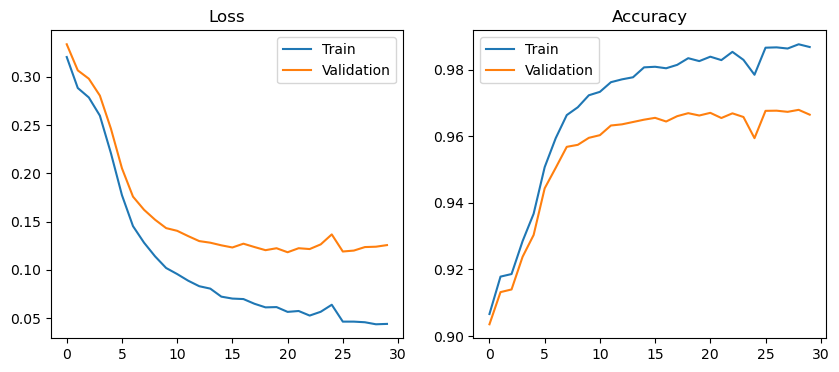

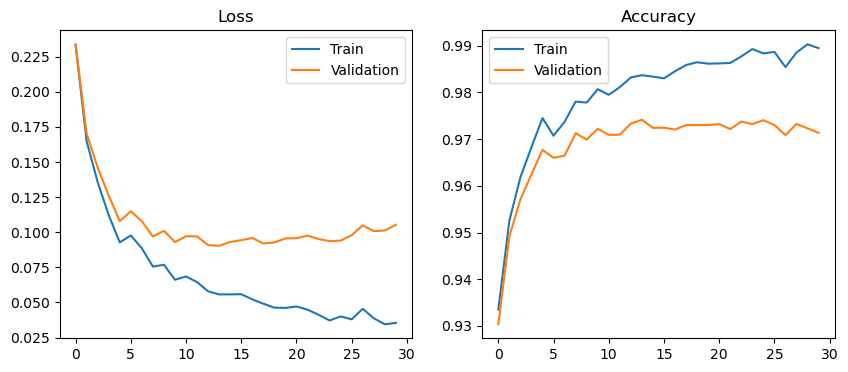

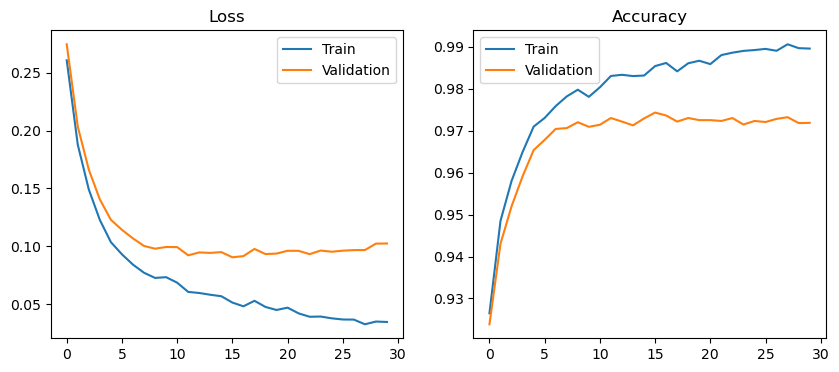

In [14]:
KFoldCrossValidation(
    ShallowCNN, 3, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', 
    learning_rate=1e-3, 
    batch_size=128, 
    epoch=30, 
    l2=1e-5,
    device=device
)

**ANSWER:** The accuracy is pretty high for such a shallow model. The model seems to overfit a bit though.

## (d)

In [43]:
class DeepCNN(nn.Module):
    def __init__(self, in_channels=1, in_dim=32):
        super().__init__()
        self.params = {
            "conv": [
                {"in_channels": in_channels, "out_channels": 33, "kernel_size": 5, "stride": 2, "padding": 0},
                {"in_channels": 33, "out_channels": 55, "kernel_size": 3, "stride": 1, "padding": 1}
            ],
            "pool": {"kernel_size": 2, "stride": 2}
        }
        self.conv = nn.ModuleList([
            nn.Conv2d(
                in_channels=self.params["conv"][0]["in_channels"], 
                out_channels=self.params["conv"][0]["out_channels"], 
                kernel_size=self.params["conv"][0]["kernel_size"], 
                stride=self.params["conv"][0]["stride"], 
                padding=self.params["conv"][0]["padding"]
            ),
            nn.Conv2d(
                in_channels=self.params["conv"][0]["out_channels"], 
                out_channels=self.params["conv"][1]["out_channels"], 
                kernel_size=self.params["conv"][1]["kernel_size"], 
                stride=self.params["conv"][1]["stride"], 
                padding=self.params["conv"][1]["padding"]
            ),
        ])
        self.pool = nn.MaxPool2d(
            kernel_size=self.params["pool"]["kernel_size"], 
            stride=self.params["pool"]["stride"]
        )
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        out_dim = self._out_dim(in_dim, self.params)
        print(f"Dimension before the first Linear layer: {out_dim * out_dim * self.params['conv'][-1]['out_channels']}")
        self.fc = nn.ModuleList([
            nn.Linear(out_dim * out_dim * self.params["conv"][-1]["out_channels"], 120),
            nn.Linear(120, 10)
        ])
    
    def forward(self, x):
        for i in range(2):
            x = self.pool(self.activation(self.conv[i](x)))
        x = self.flatten(x)
        x = self.fc[0](x)
        x = self.fc[1](x)
        return x

    def _out_dim_conv(self, in_dim, kernel_size, padding, stride, dilation=1):
        return (in_dim + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

    def _out_dim_max_pool(self, in_dim, filter_size, stride):
        return (in_dim - filter_size) // stride + 1

    def _out_dim(self, in_dim, params):
        for i in range(len(params)):
            out_dim = self._out_dim_conv(
                in_dim, params["conv"][i]["kernel_size"], 
                params["conv"][i]["padding"], 
                params["conv"][i]["stride"]
            )
            out_dim = self._out_dim_max_pool(
                out_dim, params["pool"]["kernel_size"], 
                params["pool"]["stride"]
            )
            in_dim = out_dim
        return out_dim

Fold 0:
Dimension before the first Linear layer: 495
-> DeepCNN - Number of parameters: 77978
-> Train and evaluate model using: mps.


func: train took: 140.3696 sec
Training accuracy: 99.61%
Test accuracy: 98.69%
Fold 1:
Dimension before the first Linear layer: 495
-> DeepCNN - Number of parameters: 77978
-> Train and evaluate model using: mps.


func: train took: 136.7804 sec
Training accuracy: 99.75%
Test accuracy: 99.00%
Fold 2:
Dimension before the first Linear layer: 495
-> DeepCNN - Number of parameters: 77978
-> Train and evaluate model using: mps.


func: train took: 137.5858 sec
Training accuracy: 99.86%
Test accuracy: 98.69%
Final results:
	-> Training accuracy: 99.74% +/- 0.10
	-> Testing accuracy: 98.79% +/- 0.15


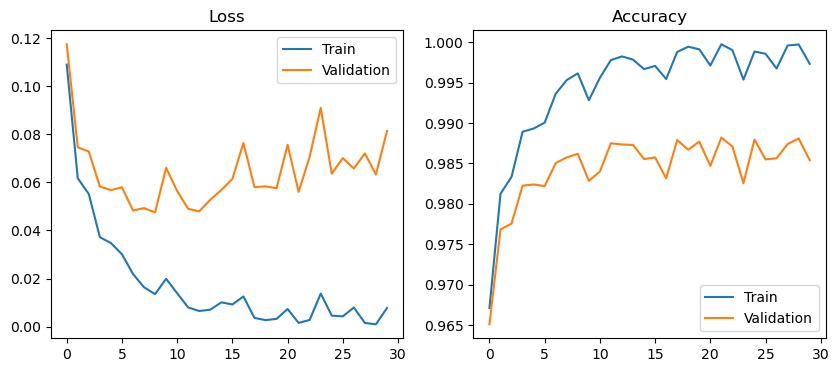

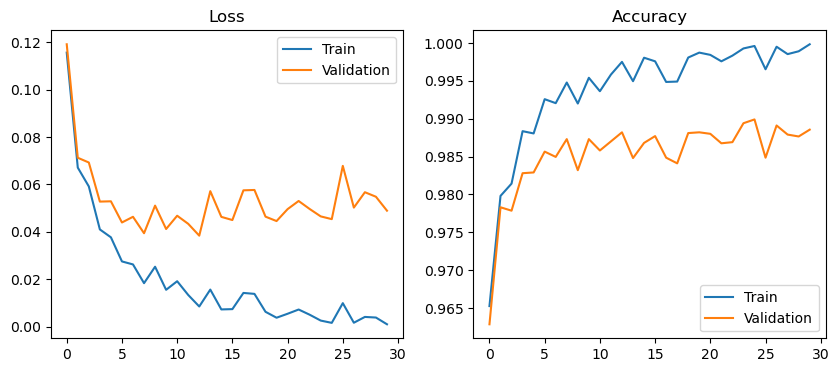

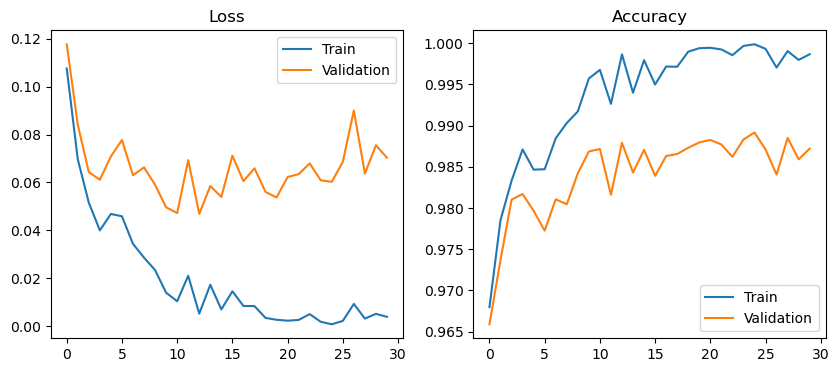

In [16]:
KFoldCrossValidation(
    DeepCNN, 3, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', 
    learning_rate=1e-3, 
    batch_size=128, 
    epoch=30, 
    l2=1e-5,
    device=device
)

**ANSWER:** A test accuracy of 98.5% is reached for this model.

# Question 2

### Instructions: You can set `early_break=True` in `KFoldCrossValidation` function to just to a train-validation round instead of doing 3-fold.

## (a)


We define our conv and pool layers so that we have an output size of 12\*5\*5:

In [17]:
in_dim = 32
out_dim_conv1 = out_dim_conv(in_dim=in_dim, kernel_size=5, padding=2, stride=2)
out_dim_pool1 = out_dim_max_pool(in_dim=out_dim_conv1, filter_size=2, stride=2)
out_dim_conv2 = out_dim_conv(in_dim=out_dim_pool1, kernel_size=5, padding=1, stride=1)
out_dim_pool2 = out_dim_max_pool(in_dim=out_dim_conv2, filter_size=2, stride=1)
print(f"out_dim: {out_dim_pool2}")

out_dim: 5


In [37]:
class ResCNNBatchNorm(nn.Module):
    def __init__(self, in_channels=1, in_dim=32):
        super().__init__()
        self.conv = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=2, padding=2),
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, stride=1, padding=1)
        ])
        self.bn = nn.ModuleList([
            nn.BatchNorm2d(6),
            nn.BatchNorm2d(12)
        ])
        self.pool = nn.ModuleList([
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=1)
        ])
        
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc = nn.ModuleList([
            nn.Linear(12 * 5 * 5, 300),
            nn.Linear(300, 10)
        ])
    
    def forward(self, x):
        for i in range(2):
            x = self.pool[i](self.activation(self.bn[i](self.conv[i](x))))
        x = self.flatten(x)
        x = x + self.fc[0](x)
        x = self.fc[1](x)
        x = nn.Softmax(dim=-1)(x)
        return x

Fold 0:
-> ResCNNBatchNorm - Number of parameters: 95314
-> Train and evaluate model using: mps.


func: train took: 119.1433 sec
Training accuracy: 99.14%
Test accuracy: 98.38%


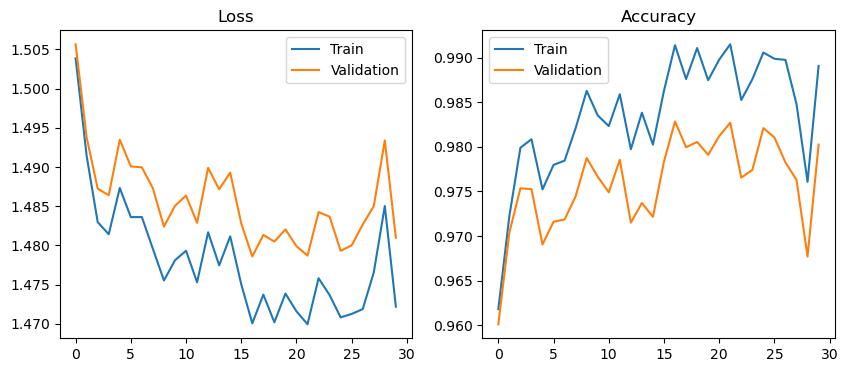

In [32]:
KFoldCrossValidation(
    ResCNNBatchNorm, 3, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', 
    learning_rate=1e-3, 
    batch_size=128, 
    epoch=30, 
    l2=1e-5,
    device=device,
    early_break=True
)

In [33]:
class ResCNN(nn.Module):
    def __init__(self, in_channels=1, in_dim=32):
        super().__init__()
        self.conv = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=2, padding=2),
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, stride=1, padding=1)
        ])
        self.pool = nn.ModuleList([
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=1)
        ])
        
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc = nn.ModuleList([
            nn.Linear(12 * 5 * 5, 300),
            nn.Linear(300, 10)
        ])
    
    def forward(self, x):
        for i in range(2):
            x = self.pool[i](self.activation(self.conv[i](x)))
        x = self.flatten(x)
        x = x + self.fc[0](x)
        x = self.fc[1](x)
        x = nn.Softmax(dim=-1)(x)
        return x

Fold 0:
-> ResCNN - Number of parameters: 95278
-> Train and evaluate model using: mps.


func: train took: 96.5956 sec
Training accuracy: 98.70%
Test accuracy: 97.80%


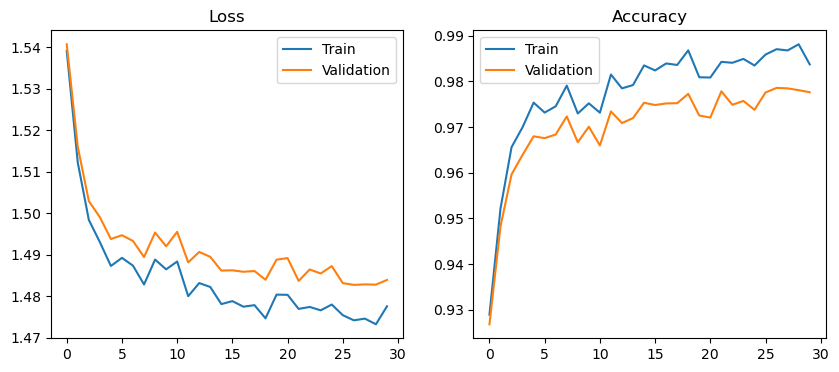

In [35]:
KFoldCrossValidation(
    ResCNN, 3, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', 
    learning_rate=1e-3, 
    batch_size=128, 
    epoch=30, 
    l2=1e-5,
    device=device,
    early_break=True
)

**ANSWER:** Here, the best test accuracy seems reached with batch normalization. 

I ran a few tests and it is not always the case, sometimes batch normalization does not particularly improve test accuracy. An explanation for that could be that the model is not complex enough to overfit and does not always require batch normalization. It could be interesting to test it on trickier data with a model more prone to overfitting.

## (b)

Fold 0:
-> ResCNNBatchNorm - Number of parameters: 95314
-> Train and evaluate model using: mps.


func: train took: 37.9842 sec
Training accuracy: 96.36%
Test accuracy: 95.47%


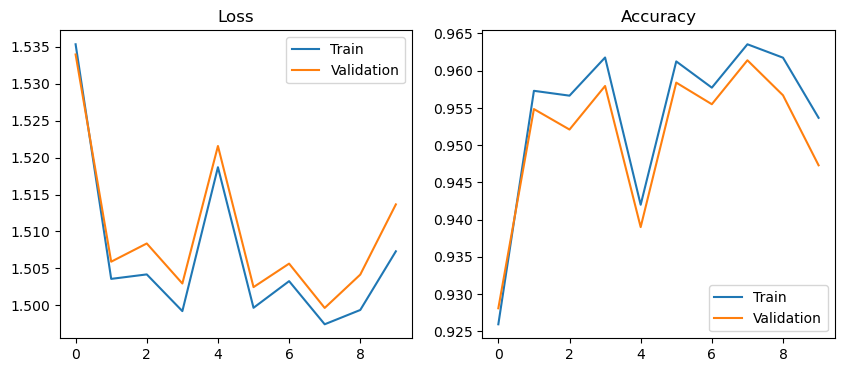

In [39]:
KFoldCrossValidation(
    ResCNNBatchNorm, 3, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', 
    learning_rate=5e-3, 
    batch_size=128, 
    epoch=10, 
    l2=1e-5,
    device=device,
    early_break=True
)

In [40]:
class CNNBatchNorm(nn.Module):
    def __init__(self, in_channels=1, in_dim=32):
        super().__init__()
        self.conv = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=2, padding=2),
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, stride=1, padding=1)
        ])
        self.bn = nn.ModuleList([
            nn.BatchNorm2d(6),
            nn.BatchNorm2d(12)
        ])
        self.pool = nn.ModuleList([
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=1)
        ])
        
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc = nn.ModuleList([
            nn.Linear(12 * 5 * 5, 300),
            nn.Linear(300, 10)
        ])
    
    def forward(self, x):
        for i in range(2):
            x = self.pool[i](self.activation(self.bn[i](self.conv[i](x))))
        x = self.flatten(x)
        x = self.fc[0](x)
        x = self.fc[1](x)
        x = nn.Softmax(dim=-1)(x)
        return x

Fold 0:
-> CNNBatchNorm - Number of parameters: 95314
-> Train and evaluate model using: mps.


func: train took: 41.0330 sec
Training accuracy: 87.34%
Test accuracy: 86.58%


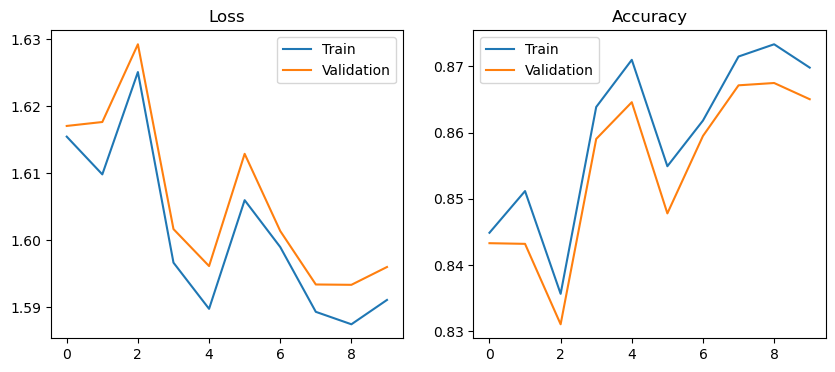

In [41]:
KFoldCrossValidation(
    CNNBatchNorm, 3, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', 
    learning_rate=5e-3, 
    batch_size=128, 
    epoch=10, 
    l2=1e-5,
    device=device,
    early_break=True
)

**ANSWER:** The training time seems to be equivalent but we observe a better test accuracy for the model with the skip connection.